In [5]:
from rxitect.models.lightning.generator import Generator
import torch
from rxitect.structs.vocabulary import SelfiesVocabulary

In [3]:
selfies_lstm = torch.load("../output/rnn/pretrained_selfies_lstm.ckpt")

In [6]:
voc = SelfiesVocabulary("../data/processed/selfies_voc.txt")
prior = Generator(vocabulary=voc)
prior.load_state_dict(selfies_lstm['state_dict'])

<All keys matched successfully>

In [20]:
from rdkit import Chem
# from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

In [8]:
x = prior.sample(10)

In [25]:
import selfies as sf

['CC(C)C(C(=O)NCCCN1N=C(C)C=C1)C2=CC=CC=C2', 'C=1C(C)C=CSC=1CCN2C(=O)CCC2C(=O)N(CCNC(=O)C(F)(F)F)C=CC=C(C(=O)N3CC=C(C4=CC=C(N)N=C4)N=N3)C=C', 'CN(C)C=CC1=C(CNCC(C(=O)NC2=CC=CC=C2C(=O)C3=CC=CC=C3)C=C[O-1])C4=CC=CC=C4N1', 'CCC(C)C1CNC(=S)N1CC2CCN(CCCC=3C=CSN=3)CC2', 'COCC(NC=NC=CC(N1CCCC1C(=O)NCC(C)NC(=O)C(N)=O)=C)C(=O)CC', 'COC1=CC=C(C(=O)NC(C(=O)NC2=CC=CC(S(=O)(=O)N3CCOCC3)=C2)C(C)C)C=C1', 'COC1=CC=C2[NH1]C=C(C3CCCC3)C2=C1', 'O=C1CCN(CC=CC2=CC=CC=C2)CC1N3CCN(C4=NC=CC=N4)CC3', 'CC1=CC=C(C(=O)NC2=CC=C(NC(=O)C3=CC=CC=C3)C=C2)C=C1CC(=O)O', 'O=C(COC(=O)C1=CC=C([N+1](=O)[O-1])O1)NC2=C(F)C(F)=C(F)C(F)=C2F']


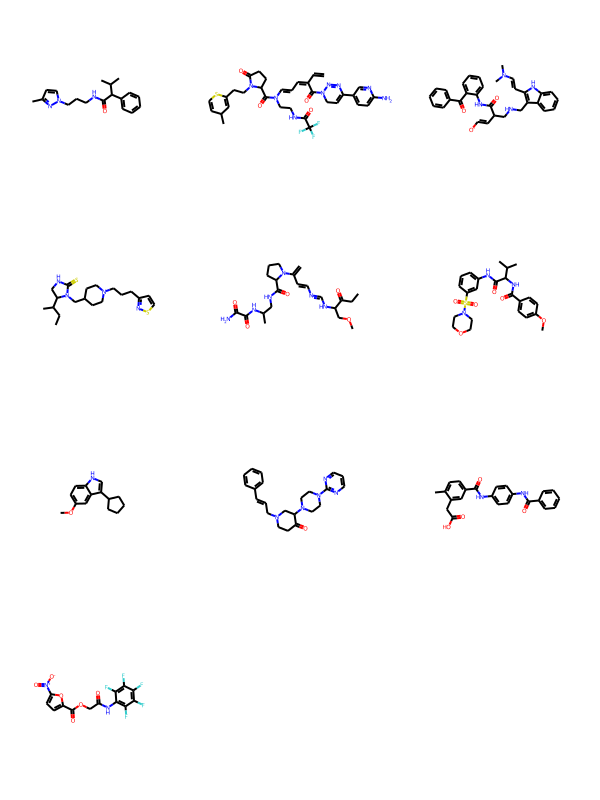

In [28]:
decoded_samples = [sf.decoder(voc.decode(sample)) for sample in x]
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in decoded_samples])

In [29]:
test_sample = prior.sample(1024)

In [36]:
decode_test_samples = [voc.decode(smp) for smp in test_sample]

In [42]:
len(list(sf.split_selfies(decode_test_samples[0])))

61

In [44]:
lengths = []
for smp in decode_test_samples:
    lengths.append(len(list(sf.split_selfies(smp))))

In [49]:
import numpy as np

np.std(lengths)

13.463247462980494

# - Make check when generating chemical space to not grow past 109 tokens
# - How should we replace the evolve step that uses NNs?